In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy
import pandas
from PIL import Image
import random
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Analysis_Figs_V6.3.1/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_SubsetA_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_SubsetA_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
    Time, Begin_Time, Compl_Time, Peak_Time = [], [], [], []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Begin_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        Compl_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["ET Begin Time"] = Begin_Time
    ET_DF["ET Complete Time"] = Compl_Time
    ET_DF["Peak Time"] = Peak_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    except:
        New_Time = numpy.nan
    return (New_Time)

In [6]:
def Month(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
        Month = New_Time.month
    except:
        Month = numpy.nan
    return (Month)

In [7]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)
VLT_Bins = Create_Bins(-600,600,50)
B_Bins = Create_Bins(-45,135,7.5)
Bins_Bounds = numpy.array([-600,600,50,-45,135,7.5])

In [8]:
Num_Years = numpy.array([90,93,93])

In [9]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [10]:
# Create Function to Calculate Phase Space Distribution
def Phase_Space_Distr(DF, VLT_Bins, B_Bins, Model, Rela):
    Length = len(DF)
    VLT_B_Count, VLT_VUT_Count = Phase_Space_Count(DF, Length, VLT_Bins, B_Bins, 0, 0, 0)
#
# Calculate Phase Space Density
    if Rela == True:
        VLT_B_Density = VLT_B_Count / Length * 1000
        VLT_VUT_Density = VLT_VUT_Count / Length * 1000
        return (VLT_B_Density, VLT_VUT_Density)
#
# Calculate Phase Space Annual
    else:
        if Model == "Control":
            Num_Year = 90
        else:
            Num_Year = 93
        VLT_B_Annual = VLT_B_Count / Num_Year
        VLT_VUT_Annual = VLT_VUT_Count / Num_Year
        return (VLT_B_Annual, VLT_VUT_Annual)

In [11]:
# Create Function to Calculate Phase Space Distribution (Smoothen)
def Phase_Space_Distr_Smooth(DF, VLT_Bins, B_Bins, Model, Rela):
# Count Phase Space Distribution
    Length = len(DF)
    Params_VLT = Create_Bins(0,25,12.5)
    Params_B = Create_Bins(0,4,2)
    Params_VUT = Create_Bins(0,25,12.5)
    VLT_B_Count_Sum = numpy.zeros((len(VLT_Bins)-1, len(B_Bins)-1))
    VLT_VUT_Count_Sum = numpy.zeros((len(VLT_Bins)-1, len(VLT_Bins)-1))
    for n in range(len(Params_VLT)):
        VLT_B_Count, VLT_VUT_Count = Phase_Space_Count(DF, Length, VLT_Bins, B_Bins, \
        Params_VLT[n], Params_B[n], Params_VUT[n])
        VLT_B_Count_Sum += VLT_B_Count
        VLT_VUT_Count_Sum += VLT_VUT_Count
    VLT_B_Count_Mean = VLT_B_Count_Sum / len(Params_VLT)
    VLT_VUT_Count_Mean = VLT_VUT_Count_Sum / len(Params_VLT)
#
# Calculate Phase Space Density
    if Rela == True:
        VLT_B_Density = VLT_B_Count_Mean / Length * 1000
        VLT_VUT_Density = VLT_VUT_Count_Mean / Length * 1000
        return (VLT_B_Density, VLT_VUT_Density)
#
# Calculate Phase Space Annual
    else:
        if Model == "Control":
            Num_Year = 90
        else:
            Num_Year = 93
        VLT_B_Annual = VLT_B_Count / Num_Year
        VLT_VUT_Annual = VLT_VUT_Count / Num_Year
        return (VLT_B_Annual, VLT_VUT_Annual)

In [12]:
# Count Phase Space Distribution
def Phase_Space_Count(DF, Length, VLT_Bins, B_Bins, Param_VLT, Param_B, Param_VUT):
    VLT_B_Count = numpy.zeros((len(VLT_Bins)-1, len(B_Bins)-1))
    VLT_VUT_Count = numpy.zeros((len(VLT_Bins)-1, len(VLT_Bins)-1))
    VLT_B_Length = 0
    VLT_VUT_Length = 0
    for i in range(len(DF["VLT"])):
        for j in range(len(VLT_Bins)-1):
            if DF["VLT"][i] >= VLT_Bins[j]-Param_VLT and DF["VLT"][i] <= VLT_Bins[j+1]+Param_VLT:
                for k in range(len(B_Bins)-1):
                    if DF["B"][i] >= B_Bins[k]-Param_B and DF["B"][i] <= B_Bins[k+1]+Param_B:
                        VLT_B_Count[j][k] += 1
                        VLT_B_Length += 1
                for l in range(len(VLT_Bins)-1):
                    if DF["VUT"][i] >= VLT_Bins[l]-Param_VUT and DF["VUT"][i] <= VLT_Bins[l+1]+Param_VUT:
                        VLT_VUT_Count[j][l] += 1
                        VLT_VUT_Length += 1
    VLT_B_Final = VLT_B_Count / VLT_B_Length * Length
    VLT_VUT_Final = VLT_VUT_Count / VLT_VUT_Length * Length
    return (VLT_B_Final, VLT_VUT_Final)

In [13]:
# Calculate Percentage of Points in Each Quadrant
def Phase_Space_Quadrant(Density, Var, Rela):
    if Rela == True:
        Density = Density / 1000
    x_Length = len(Density)
    y_Length = len(Density[0])
    x_Mid = int(x_Length / 2)
    Right_Half = Density[x_Mid:]
    Left_Half = Density[:x_Mid]
    Q1, Q2, Q3, Q4 = 0, 0, 0, 0
    if Var == "VUT":
        y_Mid = int(y_Length / 2)
    elif Var == "B":
        y_Mid = int(y_Length / 3)
    for i in range(len(Right_Half)):
        Top_Right = numpy.sum(Right_Half[i][y_Mid:])
        Q1 += Top_Right
        Bottom_Right = numpy.sum(Right_Half[i][:y_Mid])
        Q4 += Bottom_Right
    for j in range(len(Left_Half)):
        Top_Left = numpy.sum(Left_Half[j][y_Mid:])
        Q2 += Top_Left
        Bottom_Left = numpy.sum(Left_Half[j][:y_Mid])
        Q3 += Bottom_Left
    return (numpy.array([Q1, Q2, Q3, Q4]))

In [14]:
# Create Function For Colours
Distr_Colours = ['lightskyblue', 'deepskyblue', 'lightseagreen', \
'limegreen', 'greenyellow', 'yellow', 'orange', 'red']
Rela_Distr_Bounds = numpy.array([0,1,2,5,10,20,30,40])
Annual_Distr_Bounds = numpy.array([0,0.1,0.2,0.5,1,2,3,4])
# Create Function For Colours
def Distr_Colour(Density, Dist_Colours, Dist_Bounds):
    for k in range(len(Dist_Colours)):
        if Density == 0:
            Colour = 'white'
        else:
            Bin = numpy.digitize(Density, bins=Dist_Bounds[1:], right=True)
            Colour = Dist_Colours[Bin]
    return (Colour)

In [15]:
# Plot Cyclone Phase Distribution
def Phase_Distr_Plot(DF, Model, Rela, Smooth, i, Colourbar, Subset):
# Use Function to Calculate Distributions
    if Smooth == False:
        VLT_B, VLT_VUT = Phase_Space_Distr(DF, VLT_Bins, B_Bins, Model, Rela)
    else:
        VLT_B, VLT_VUT = Phase_Space_Distr_Smooth(DF, VLT_Bins, B_Bins, Model, Rela)
#
# Define Colours and Bounds
    if Rela == True:
        Bounds = Rela_Distr_Bounds
        Colours = Distr_Colours
    else:
        Bounds = Annual_Distr_Bounds
        Colours = Distr_Colours
#
# VLT B Distribution
    Axis = Fig.add_subplot(3,2,i*2+1)
    for j in range(len(VLT_B)):
        for k in range(len(VLT_B[0])):
            Colour = Distr_Colour(VLT_B[j][k], Colours, Bounds)
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], B_Bins[k], B_Bins[k+1], color=Colour)
    Phase_Distr_Formatting("B", Model, Rela, Axis, Subset)
# Add Quadrant Percent
    Quadrant_Percent = Phase_Space_Quadrant(VLT_B, "B", Rela)
    xloc = [0.88,0.12,0.12,0.88]
    yloc = [0.88,0.88,0.12,0.12]
    for q in range(len(Quadrant_Percent)):
        if Rela == True:
            Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
        else:
            Axis.text(xloc[q], yloc[q], str('%5.2f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
#
# VLT VUT Distribution
    Axis = Fig.add_subplot(3,2,i*2+2)
    for j in range(len(VLT_VUT)):
        for l in range(len(VLT_VUT[0])):
            Colour = Distr_Colour(VLT_VUT[j][l], Colours, Bounds)
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], VLT_Bins[l], VLT_Bins[l+1], color=Colour)
    Phase_Distr_Formatting("VUT", Model, Rela, Axis, Subset)
# Add Quadrant Percent
    Quadrant_Percent = Phase_Space_Quadrant(VLT_VUT, "VUT", Rela)
    xloc = [0.88,0.12,0.12,0.88]
    yloc = [0.88,0.88,0.12,0.12]
    for q in range(len(Quadrant_Percent)):
        if Rela == True:
            Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
        else:
            Axis.text(xloc[q], yloc[q], str('%5.2f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
#
# Colour Bar
    if Colourbar == True:
        if Rela == True:
            Cbar_Label = 'Density (Per 1000 Data Points)'
        else:
            Cbar_Label = 'Density (Per Year)'
        C_Map = mcolors.LinearSegmentedColormap.from_list("Density (10^-3)", Colours, N=len(Colours))
        Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='max')
        Cax = Axis.inset_axes([-0.6, -0.085, 1, 0.03], transform=Axis.transAxes)
        Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
        label=Cbar_Label, ticks=Bounds, shrink=0.7)

In [16]:
# Formatting For Cyclone Phase Distribution Plot
def Phase_Distr_Formatting(y_Var, Model, Rela, Axis, Subset):
    x_Axis = Create_Bins(Bins_Bounds[0],Bins_Bounds[1],100)
    pyplot.xlim(Bins_Bounds[0],Bins_Bounds[1])
    if y_Var == "B":
        y_Axis = Create_Bins(Bins_Bounds[3],Bins_Bounds[4],15)
        pyplot.ylim(Bins_Bounds[3],Bins_Bounds[4])
        pyplot.plot([-1000,1000], [15,15], 'black', linewidth=0.5)
        pyplot.plot([0,0], [-150,300], 'black', linewidth=0.5)
    else:
        y_Axis = Create_Bins(Bins_Bounds[0],Bins_Bounds[1],100)
        pyplot.ylim(Bins_Bounds[0],Bins_Bounds[1])
        pyplot.plot([-1000,1000], [0,0], 'black', linewidth=0.5)
        pyplot.plot([0,0], [-1000,1000], 'black', linewidth=0.5)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel(y_Var, fontsize=12)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    if Subset == "":
        pyplot.title(Model, fontsize=20)
#        if Rela == True:
#            pyplot.title(str(Model + ' (Relative)'), fontsize=20)
#        else:
#            pyplot.title(str(Model + ' (Annual)'), fontsize=20)
    else:
        pyplot.title(str(Model + ' (' + Subset + ')'), fontsize=18)

In [17]:
# Calculate Difference Between Models
def Phase_Space_Diff(DF_1, DF_2, Model_1, Model_2, Rela, Smooth):
    if Smooth == False:
        VLT_B_1, VLT_VUT_1 = Phase_Space_Distr(DF_1, VLT_Bins, B_Bins, Model_1, Rela)
        VLT_B_2, VLT_VUT_2 = Phase_Space_Distr(DF_2, VLT_Bins, B_Bins, Model_2, Rela)
    else:
        VLT_B_1, VLT_VUT_1 = Phase_Space_Distr_Smooth(DF_1, VLT_Bins, B_Bins, Model_1, Rela)
        VLT_B_2, VLT_VUT_2 = Phase_Space_Distr_Smooth(DF_2, VLT_Bins, B_Bins, Model_2, Rela)
    VLT_B_Diff = VLT_B_1 - VLT_B_2
    VLT_VUT_Diff = VLT_VUT_1 - VLT_VUT_2
    VLT_B_Quadrant_Percent = Phase_Space_Quadrant(VLT_B_1, "B", Rela) - Phase_Space_Quadrant(VLT_B_2, "B", Rela)
    VLT_VUT_Quadrant_Percent = Phase_Space_Quadrant(VLT_VUT_1, "VUT", Rela) - Phase_Space_Quadrant(VLT_VUT_2, "VUT", Rela)
    return (VLT_B_Diff, VLT_VUT_Diff, VLT_B_Quadrant_Percent, VLT_VUT_Quadrant_Percent)

In [18]:
# Create Function of Colours of Cyclone Phase Difference Plots
Diff_Colours = ['mediumblue', 'deepskyblue', 'cyan', 'lawngreen', \
'gold', 'darkorange', 'red']
Rela_Diff_Bounds = numpy.array([-5,-3,-1.5,1.5,3,5])
Annual_Diff_Bounds = numpy.array([-2,-1,-0.5,0.5,1,2])
#
def Diff_Colour(Diff, Diff_Colours, Diff_Bounds):
    for k in range(len(Diff_Colours)):
        if Diff == 0:
            Colour = 'white'
        else:
            Bin = numpy.digitize(Diff, bins=Diff_Bounds, right=True)
            Colour = Diff_Colours[Bin]
    return (Colour)

In [19]:
# Plot Cyclone Phase Distribution Difference Between ERA and REA
def Phase_Diff_Plot(DF_1, DF_2, Model_1, Model_2, Rela, Smooth, i, Colourbar, Subset):
    VLT_B_Diff, VLT_VUT_Diff, VLT_B_Quadrant_Percent, VLT_VUT_Quadrant_Percent = \
    Phase_Space_Diff(DF_1, DF_2, Model_1, Model_2, Rela, Smooth)
#
# Define Colours and Bounds
    if Rela == True:
        Diff_Bounds = Rela_Diff_Bounds
    else:
        Diff_Bounds = Annual_Diff_Bounds
#
# VLT B Distribution
    Axis = Fig.add_subplot(3,2,i*2+1)
    for j in range(len(VLT_B_Diff)):
        for k in range(len(VLT_B_Diff[0])):
            Colour = Diff_Colour(VLT_B_Diff[j][k], Diff_Colours, Diff_Bounds)
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], B_Bins[k], B_Bins[k+1], color=Colour)
    Phase_Diff_Formatting("B", Model_1, Model_2, Rela, Axis, Subset)
# Add Quadrant Percent
    xloc = [0.88,0.12,0.12,0.88]
    yloc = [0.88,0.88,0.12,0.12]
    for q in range(len(VLT_B_Quadrant_Percent)):
        if Rela == True:
            Axis.text(xloc[q], yloc[q], str('%5.3f' % VLT_B_Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
        else:
            Axis.text(xloc[q], yloc[q], str('%5.2f' % VLT_B_Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
#
# VLT VUT Distribution
    Axis = Fig.add_subplot(3,2,i*2+2)
    for j in range(len(VLT_VUT_Diff)):
        for l in range(len(VLT_VUT_Diff[0])):
            Colour = Diff_Colour(VLT_VUT_Diff[j][l], Diff_Colours, Diff_Bounds)
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], VLT_Bins[l], VLT_Bins[l+1], color=Colour)
    Phase_Diff_Formatting("VUT", Model_1, Model_2, Rela, Axis, Subset)
# Add Quadrant Percent
    xloc = [0.88,0.12,0.12,0.88]
    yloc = [0.88,0.88,0.12,0.12]
    for q in range(len(VLT_VUT_Quadrant_Percent)):
        if Rela == True:
            Axis.text(xloc[q], yloc[q], str('%5.3f' % VLT_VUT_Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
        else:
            Axis.text(xloc[q], yloc[q], str('%5.2f' % VLT_VUT_Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
#
# Colour Bar
    if Colourbar == True:
        if Rela == True:
            Cbar_Label = 'Density Diff (Per 1000 Data Points)'
        else:
            Cbar_Label = 'Density Diff (Per Year)'
        C_Map = mcolors.LinearSegmentedColormap.from_list("Density (10^-3)", Diff_Colours, N=len(Diff_Colours))
        Norm = mcolors.BoundaryNorm(Diff_Bounds, C_Map.N, extend='both')
        Cax = Axis.inset_axes([-0.6, -0.085, 1, 0.03], transform=Axis.transAxes)
        Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
        label=Cbar_Label, ticks=Diff_Bounds, shrink=0.7)

In [20]:
# Formatting For Cyclone Phase Difference Plot
def Phase_Diff_Formatting(y_Var, Model_1, Model_2, Rela, Axis, Subset):
    x_Axis = Create_Bins(Bins_Bounds[0],Bins_Bounds[1],100)
    pyplot.xlim(Bins_Bounds[0],Bins_Bounds[1])
    if y_Var == "B":
        y_Axis = Create_Bins(Bins_Bounds[3],Bins_Bounds[4],15)
        pyplot.ylim(Bins_Bounds[3],Bins_Bounds[4])
        pyplot.plot([-1000,1000], [15,15], 'black', linewidth=0.5)
        pyplot.plot([0,0], [-150,300], 'black', linewidth=0.5)
    else:
        y_Axis = Create_Bins(Bins_Bounds[0],Bins_Bounds[1],100)
        pyplot.ylim(Bins_Bounds[0],Bins_Bounds[1])
        pyplot.plot([-1000,1000], [0,0], 'black', linewidth=0.5)
        pyplot.plot([0,0], [-1000,1000], 'black', linewidth=0.5)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel(y_Var, fontsize=12)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    if Subset == "":
        pyplot.title(str(Model_1 + ' - ' + Model_2), fontsize=20)
#        if Rela == True:
#            pyplot.title(str(Model_1 + ' - ' + Model_2 + ' (Relative)'), fontsize=20)
#        else:
#            pyplot.title(str(Model_1 + ' - ' + Model_2 + ' (Annual)'), fontsize=20)
    else:
        pyplot.title(str(Model_1 + ' - ' + Model_2 + ' (' + Subset + ')'), fontsize=18)

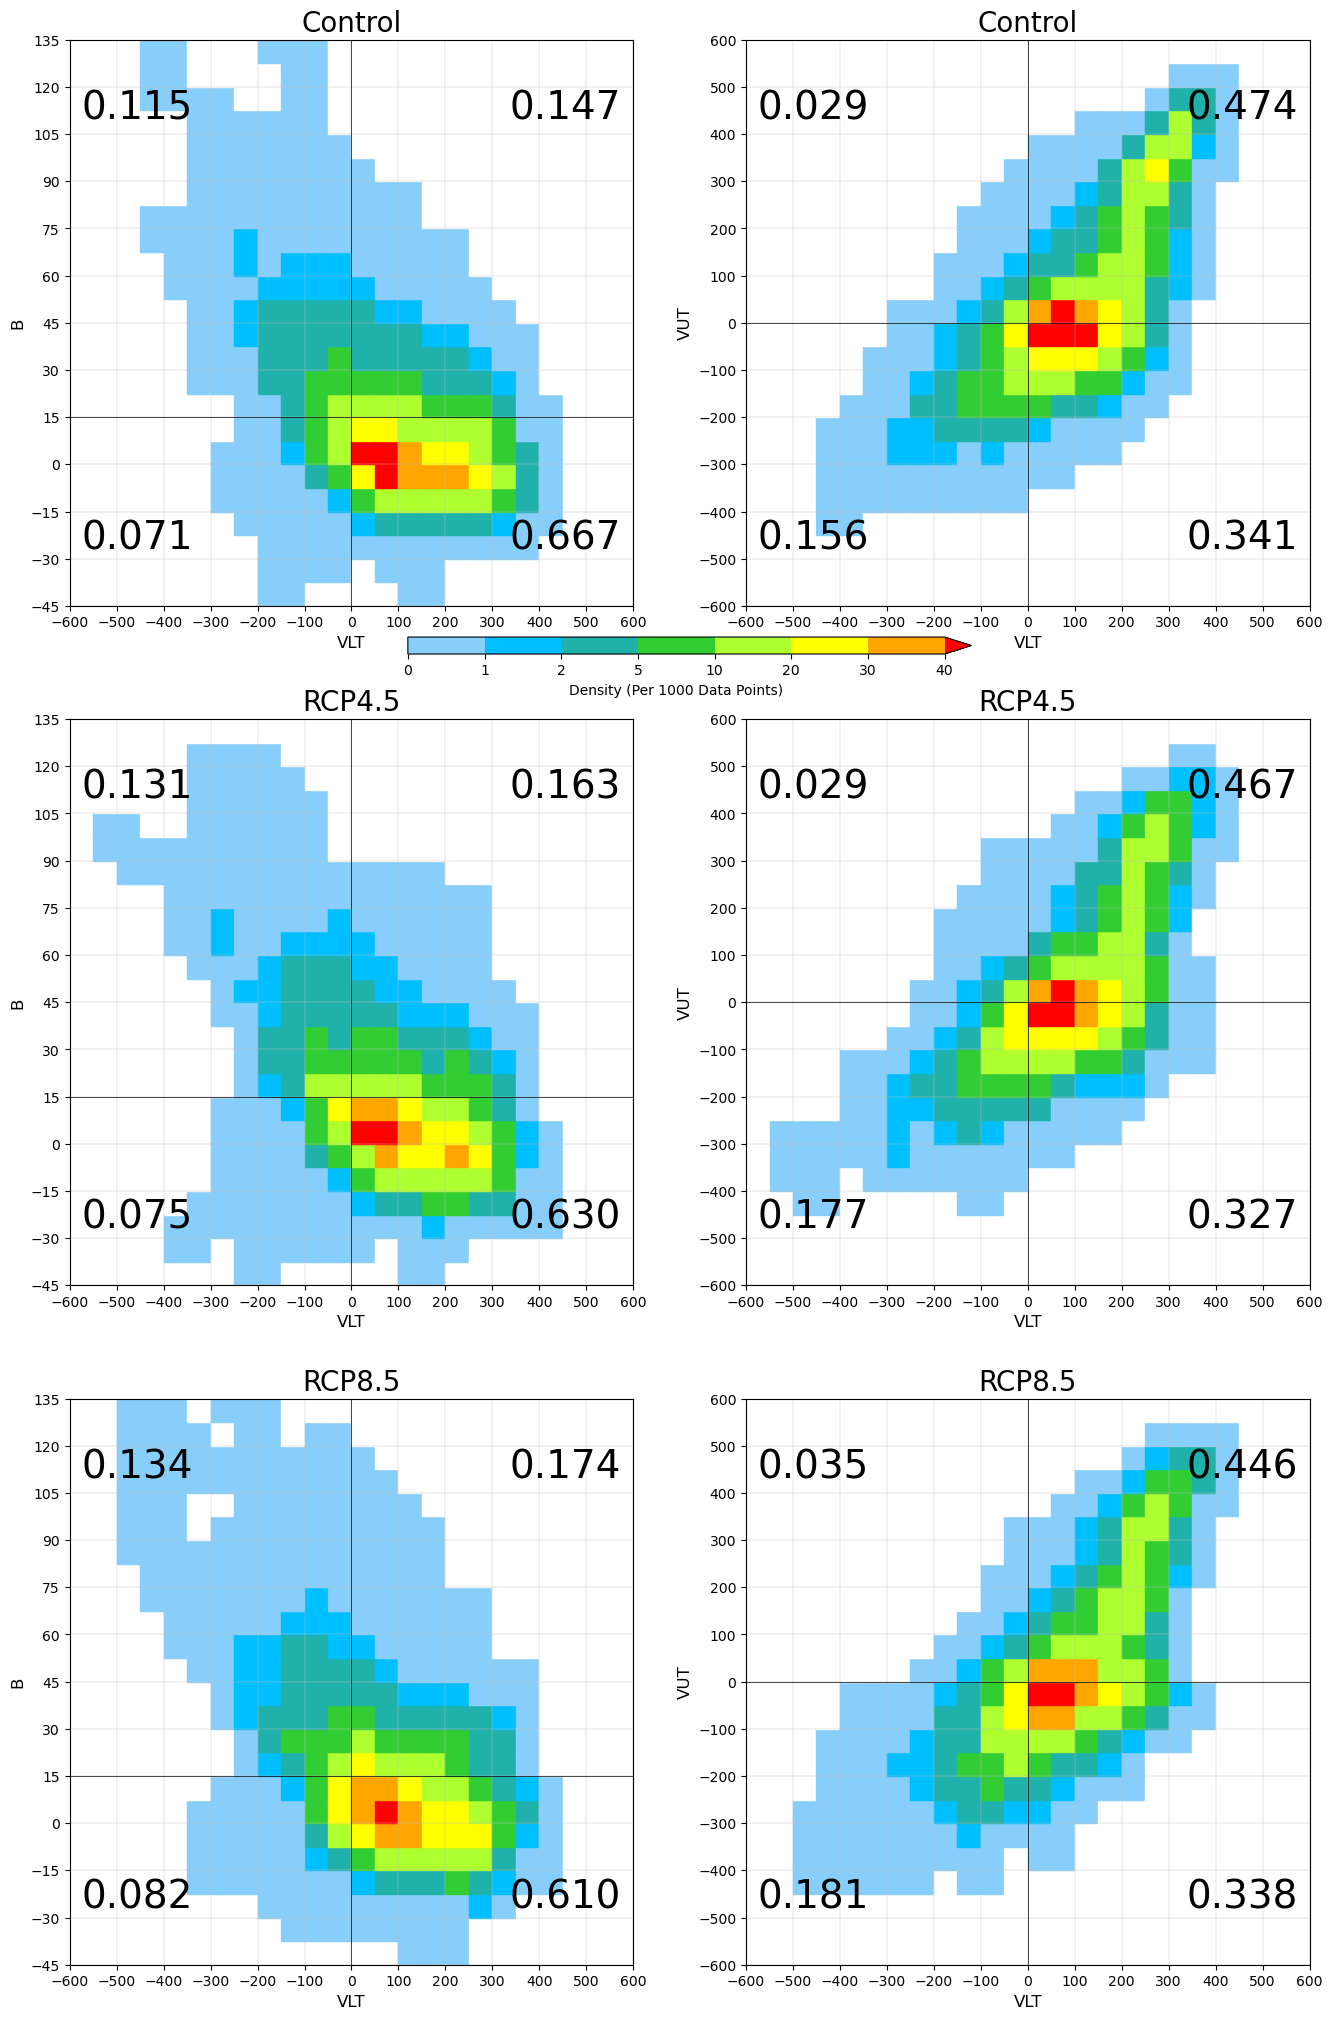

In [21]:
# Plot Phase Space Distributions (Relative)
Fig = pyplot.figure(figsize=(16,25))
Phase_Distr_Plot(Control_Data, "Control", True, True, 0, True, "")
Phase_Distr_Plot(RCP45_Data, "RCP4.5", True, True, 1, False, "")
Phase_Distr_Plot(RCP85_Data, "RCP8.5", True, True, 2, False, "")
Fig.savefig(Output_Diri+'Phase_Distr_Rela.png', bbox_inches='tight')

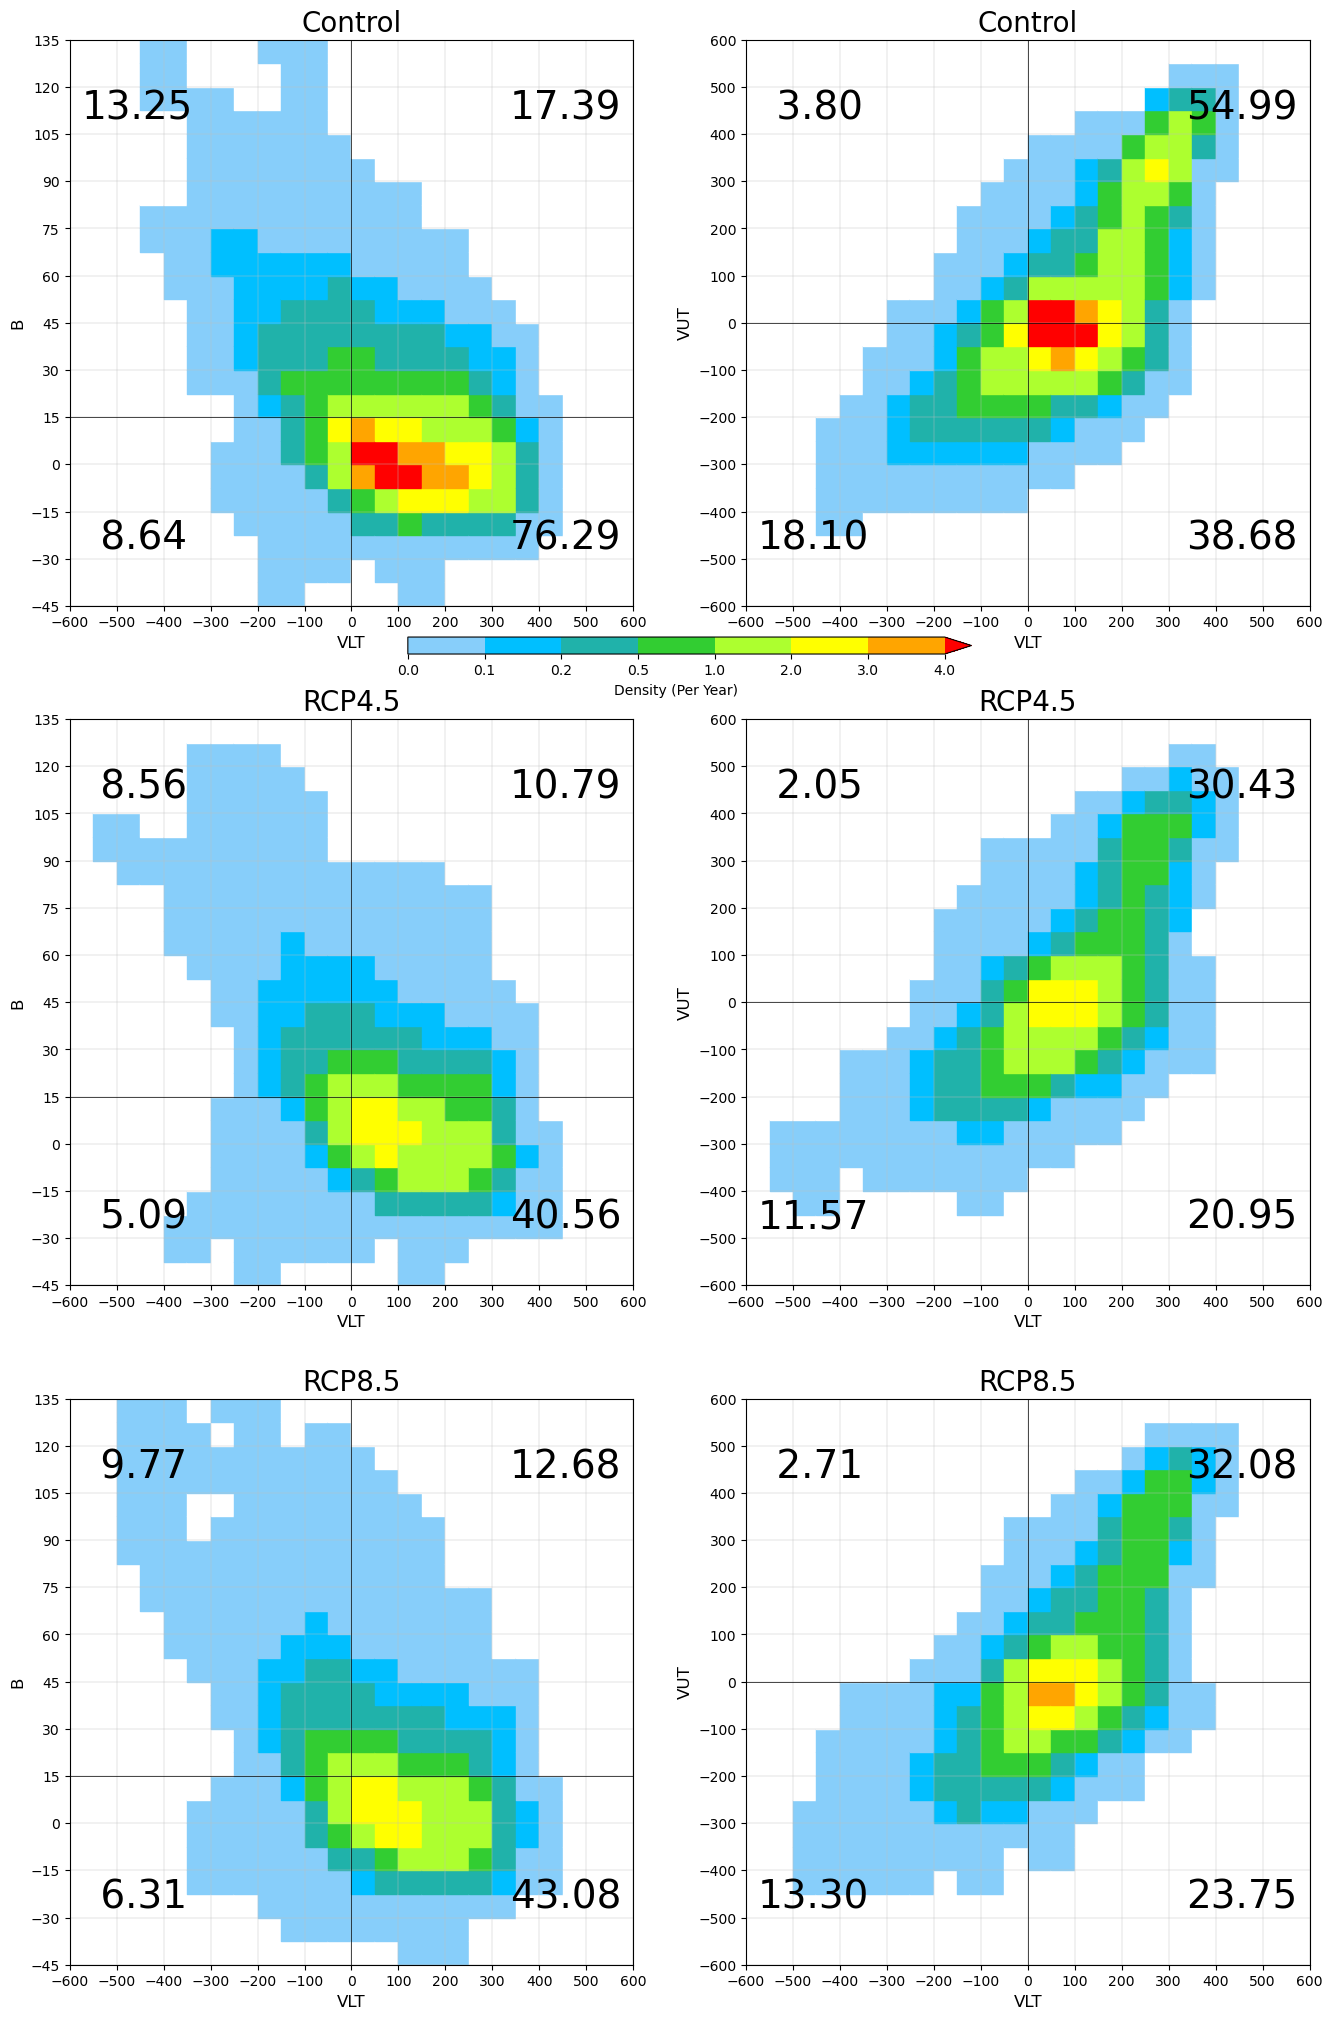

In [22]:
# Plot Phase Space Distributions (Annual)
Fig = pyplot.figure(figsize=(16,25))
Phase_Distr_Plot(Control_Data, "Control", False, True, 0, True, "")
Phase_Distr_Plot(RCP45_Data, "RCP4.5", False, True, 1, False, "")
Phase_Distr_Plot(RCP85_Data, "RCP8.5", False, True, 2, False, "")
Fig.savefig(Output_Diri+'Phase_Distr_Annual.png', bbox_inches='tight')

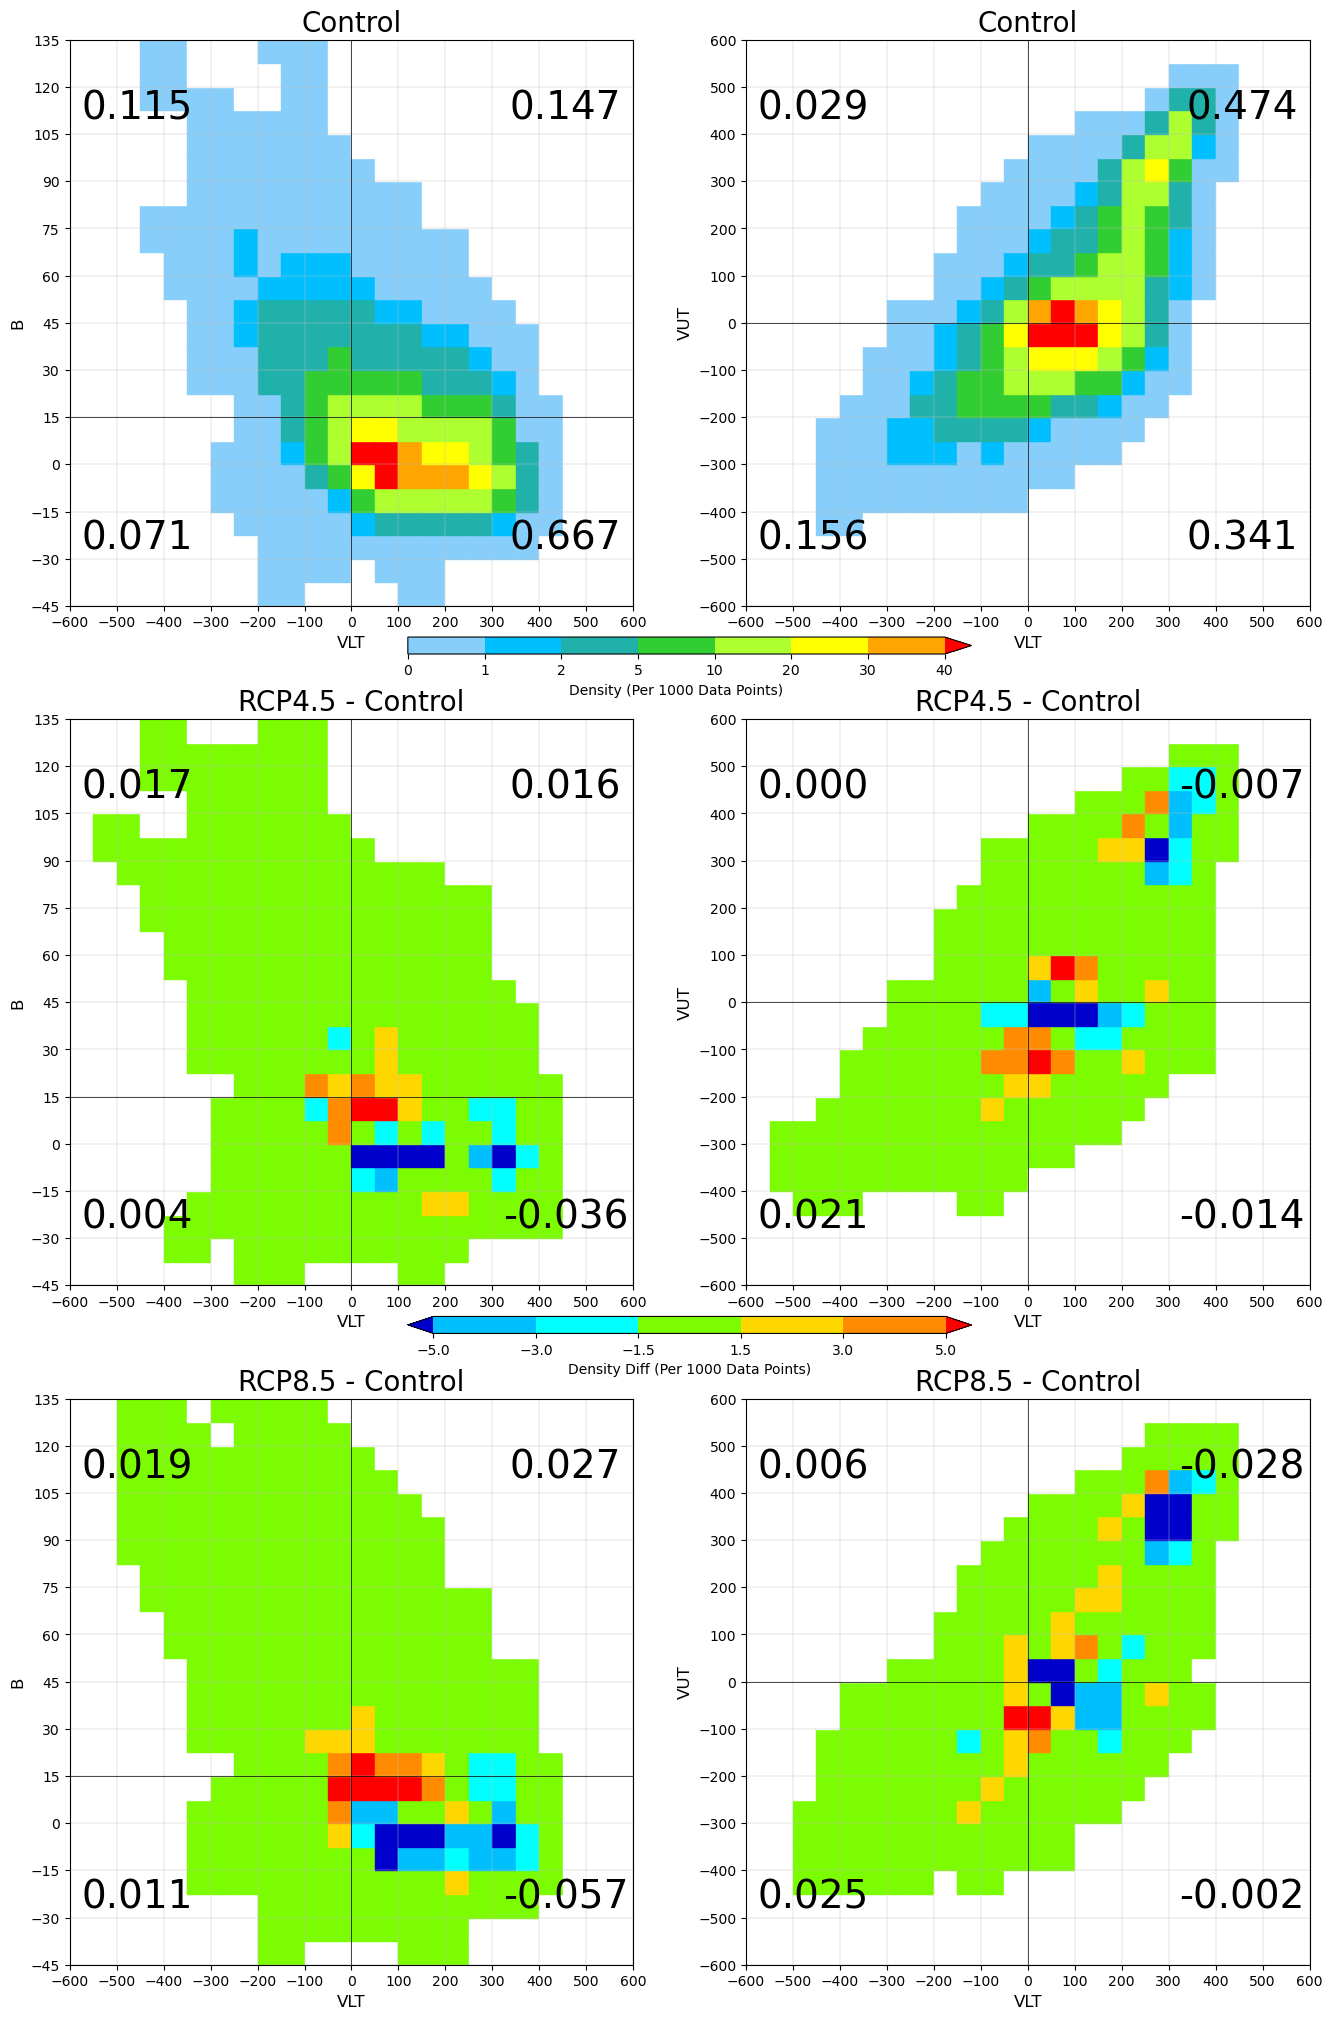

In [23]:
# Plot Differences Between Phase Space Distributions (Relative)
Fig = pyplot.figure(figsize=(16,25))
Phase_Distr_Plot(Control_Data, "Control", True, True, 0, True, "")
Phase_Diff_Plot(RCP45_Data, Control_Data, "RCP4.5", "Control", True, True, 1, True, "")
Phase_Diff_Plot(RCP85_Data, Control_Data, "RCP8.5", "Control", True, True, 2, False, "")
Fig.savefig(Output_Diri+'Phase_Diff_Rela.png', bbox_inches='tight')

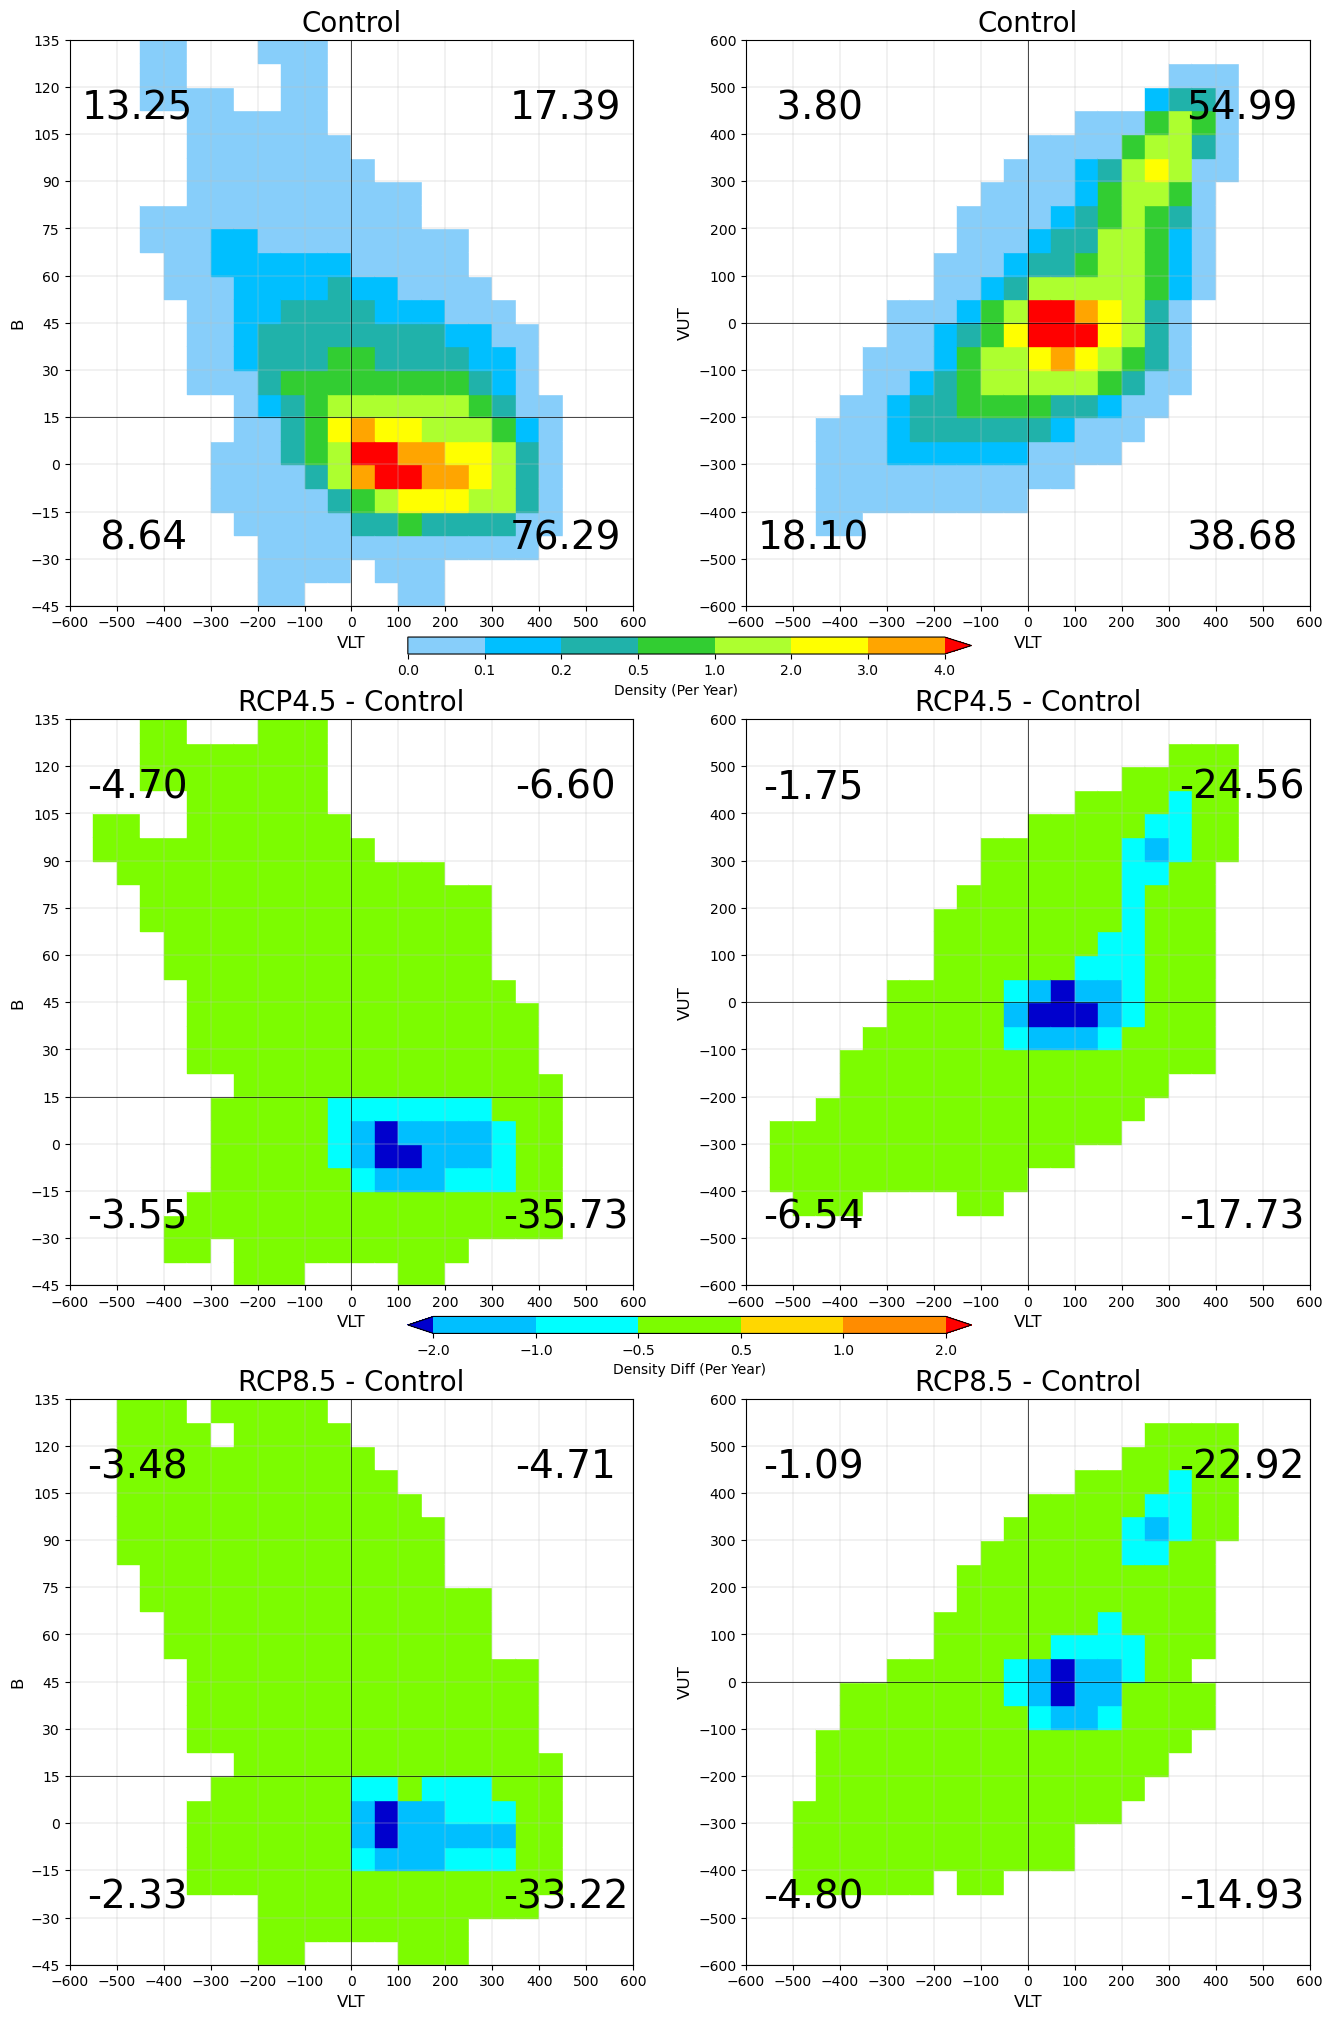

In [24]:
# Plot Differences Between Phase Space Distributions (Annual)
Fig = pyplot.figure(figsize=(16,25))
Phase_Distr_Plot(Control_Data, "Control", False, True, 0, True, "")
Phase_Diff_Plot(RCP45_Data, Control_Data, "RCP4.5", "Control", False, True, 1, True, "")
Phase_Diff_Plot(RCP85_Data, Control_Data, "RCP8.5", "Control", False, True, 2, False, "")
Fig.savefig(Output_Diri+'Phase_Diff_Annual.png', bbox_inches='tight')

In [25]:
# Create Subset of Data: Below 980hPa
Control_980hPa = Control_Data[Control_Data["SLP(hPa)"] <= 980].reset_index()
RCP45_980hPa = RCP45_Data[RCP45_Data["SLP(hPa)"] <= 980].reset_index()
RCP85_980hPa = RCP85_Data[RCP85_Data["SLP(hPa)"] <= 980].reset_index()

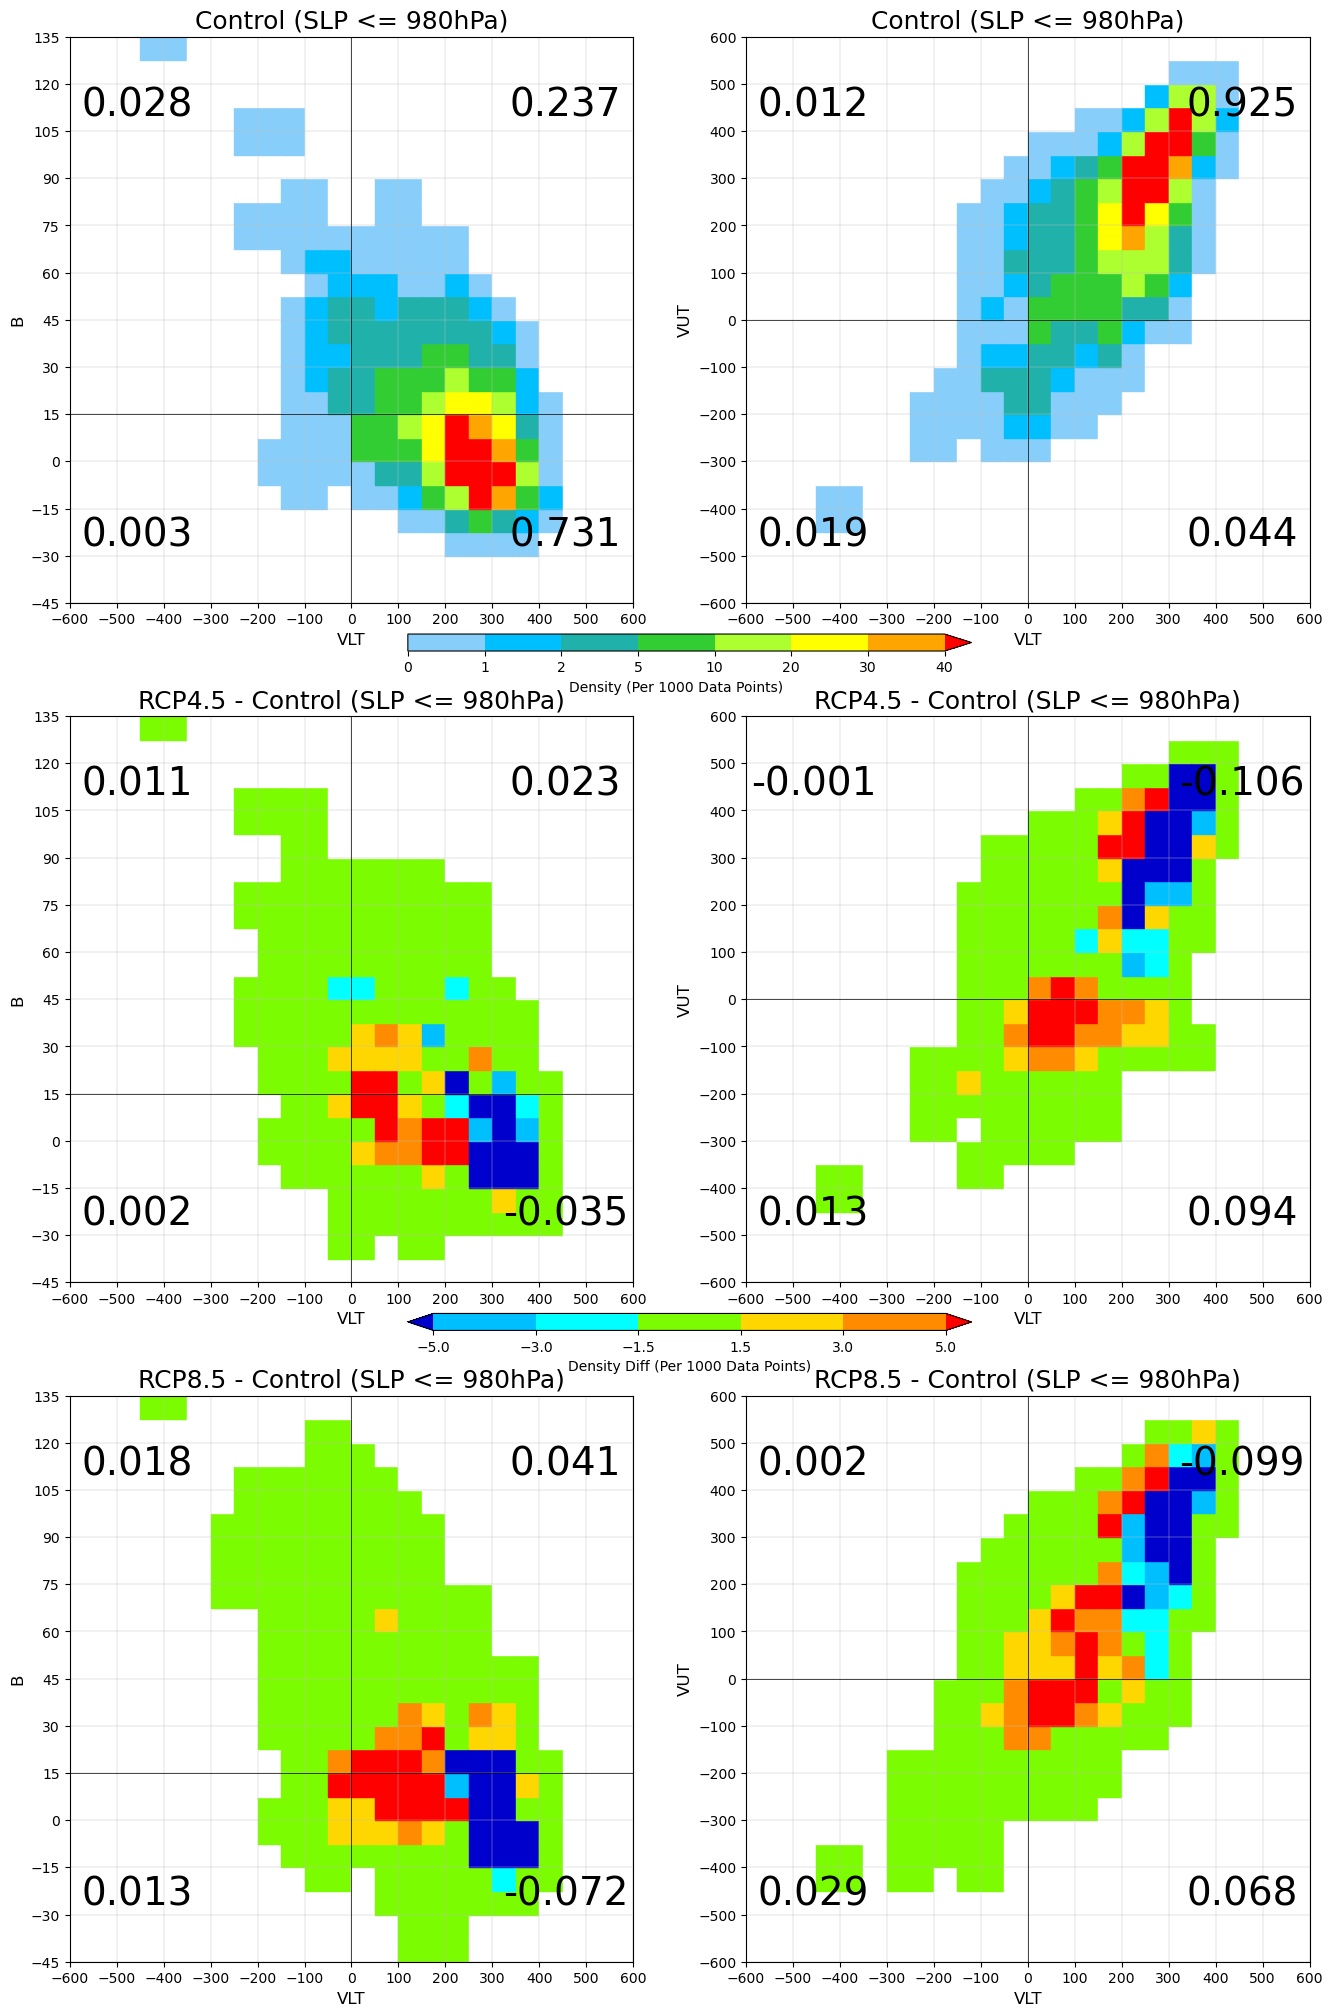

In [26]:
# Plot Differences Between Phase Space Distributions (Relative)
Fig = pyplot.figure(figsize=(16,25))
Phase_Distr_Plot(Control_980hPa, "Control", True, True, 0, True, "SLP <= 980hPa")
Phase_Diff_Plot(RCP45_980hPa, Control_980hPa, "RCP4.5", "Control", True, True, 1, True, "SLP <= 980hPa")
Phase_Diff_Plot(RCP85_980hPa, Control_980hPa, "RCP8.5", "Control", True, True, 2, False, "SLP <= 980hPa")
Fig.savefig(Output_Diri+'Phase_Diff_Rela_980hPa.png', bbox_inches='tight')